In [264]:
import numpy as np
import argparse
import imutils
import time
import cv2

%matplotlib inline
from matplotlib import pyplot as plt

In [265]:
params = {
    'model' : 'enet-cityscapes/enet-model.net',
    'classes': 'enet-cityscapes/enet-classes.txt',
    'colors': 'enet-cityscapes/enet-colors.txt',
    'image': 'images/example_04.png'
}
WITDH = 500

In [266]:
CLASSES = open(params["classes"]).read().strip().split("\n")

In [267]:
print(CLASSES)

['Unlabeled', 'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole', 'TrafficLight', 'TrafficSign', 'Vegetation', 'Terrain', 'Sky', 'Person', 'Rider', 'Car', 'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle']


In [268]:
# if a colors file was supplied, load it from disk
if params["colors"]:
	COLORS = open(params["colors"]).read().strip().split("\n")
	COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
	COLORS = np.array(COLORS, dtype="uint8")

# otherwise, we need to randomly generate RGB colors for each class
# label
else:
	# initialize a list of colors to represent each class label in
	# the mask (starting with 'black' for the background/unlabeled
	# regions)
	np.random.seed(42)
	COLORS = np.random.randint(0, 255, size=(len(CLASSES) - 1, 3),
		dtype="uint8")
	COLORS = np.vstack([[0, 0, 0], COLORS]).astype("uint8")

In [269]:
print(COLORS)

[[  0   0   0]
 [ 81   0  81]
 [244  35 232]
 [ 70  70  70]
 [102 102 156]
 [190 153 153]
 [153 153 153]
 [250 170  30]
 [220 220   0]
 [107 142  35]
 [152 251 152]
 [ 70 130 180]
 [220  20  60]
 [255   0   0]
 [  0   0 142]
 [  0   0  70]
 [  0  60 100]
 [  0  80 100]
 [  0   0 230]
 [119  11  32]]


In [270]:
# initialize the legend visualization
legend = np.zeros(((len(CLASSES) * 25) + 25, 300, 3), dtype="uint8")

# loop over the class names + colors
for (i, (className, color)) in enumerate(zip(CLASSES, COLORS)):
	# draw the class name + color on the legend
	color = [int(c) for c in color]
	cv2.putText(legend, className, (5, (i * 25) + 17),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
	cv2.rectangle(legend, (100, (i * 25)), (300, (i * 25) + 25),
		tuple(color), -1)

In [271]:
# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNet(params["model"])

# load the input image, resize it, and construct a blob from it,
# but keeping mind mind that the original input image dimensions
# ENet was trained on was 1024x512
image = cv2.imread(params["image"])
image = imutils.resize(image, width=WITDH)
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (1024, 512), 0, swapRB=True, crop=False)

# perform a forward pass using the segmentation model
net.setInput(blob)
start = time.time()
output = net.forward()
end = time.time()

# show the amount of time inference took
print("[INFO] inference took {:.4f} seconds".format(end - start))

[INFO] loading model...
[INFO] inference took 0.4593 seconds


In [272]:
# infer the total number of classes along with the spatial dimensions
# of the mask image via the shape of the output array
(numClasses, height, width) = output.shape[1:4]

# our output class ID map will be num_classes x height x width in
# size, so we take the argmax to find the class label with the
# largest probability for each and every (x, y)-coordinate in the
# image
classMap = np.argmax(output[0], axis=0)

# given the class ID map, we can map each of the class IDs to its
# corresponding color
mask = COLORS[classMap]

# resize the mask and class map such that its dimensions match the
# original size of the input image (we're not using the class map
# here for anything else but this is how you would resize it just in
# case you wanted to extract specific pixels/classes)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]),
	interpolation=cv2.INTER_NEAREST)
classMap = cv2.resize(classMap, (image.shape[1], image.shape[0]),
	interpolation=cv2.INTER_NEAREST)

# perform a weighted combination of the input image with the mask to
# form an output visualization
output = ((0.4 * image) + (0.6 * mask)).astype("uint8")

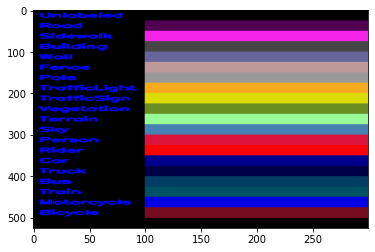

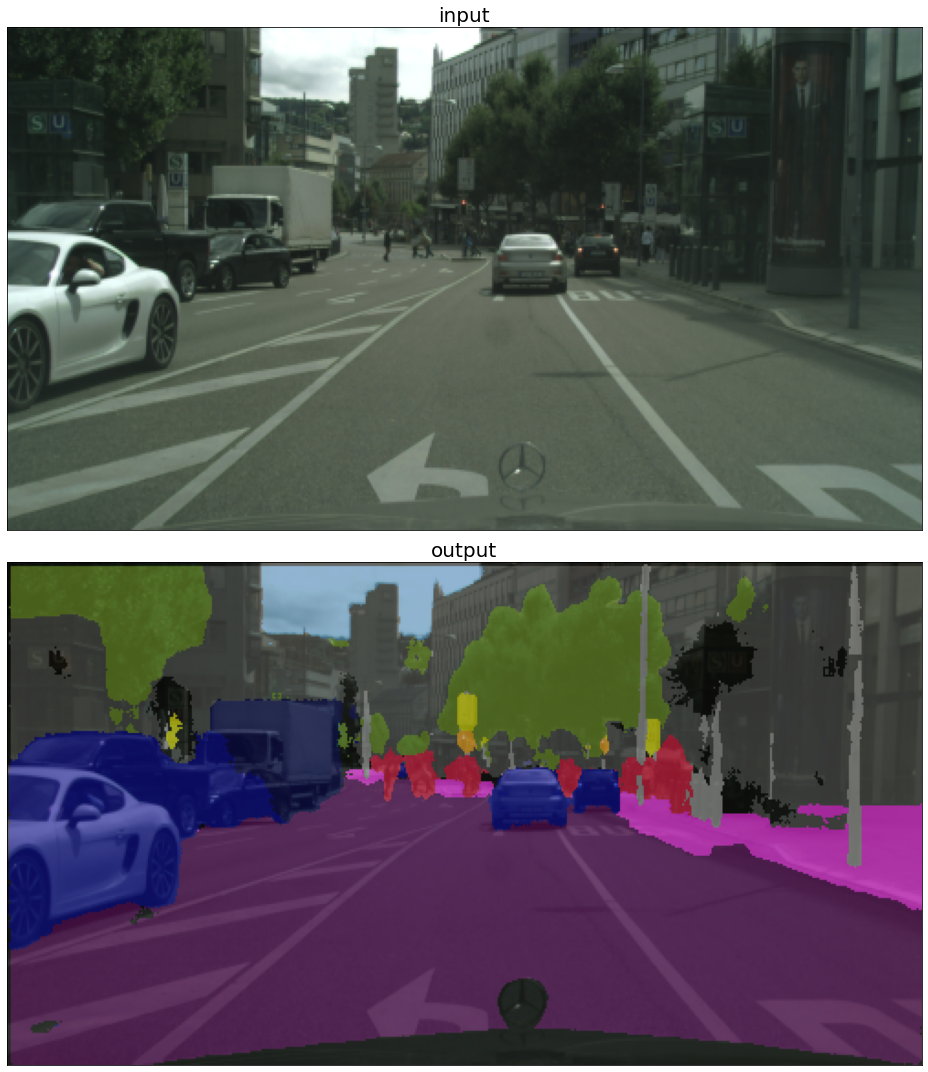

In [273]:
plt.imshow(legend, aspect='auto')
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13,15))

img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax1.imshow(img_rgb, aspect='auto')
ax1.set_title('input',fontsize= 20)
ax1.set(xticklabels=[])  
ax1.set(xlabel=None) 
ax1.set(yticklabels=[])  
ax1.set(ylabel=None) 
ax1.tick_params(left=False) 
ax1.tick_params(bottom=False) 
 
ax2.imshow(output,aspect='auto')
ax2.set_title('output',fontsize= 20)
ax2.set(xticklabels=[])  
ax2.set(xlabel=None) 
ax2.set(yticklabels=[])  
ax2.set(ylabel=None) 
ax2.tick_params(left=False) 
ax2.tick_params(bottom=False) 

plt.tight_layout()
plt.show()
